In [1]:
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as smm
from statsmodels.sandbox.stats.multicomp import multipletests 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Задание:**
*    проанализировать АБ тест, проведённый на реальных пользователях Яндекса;
*    подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной (control) и тестовой (exp) группами;
*    определить характер этих изменений и практическую значимость вводимого изменения;
*    понять, какая из пользовательских групп более всего проигрывает / выигрывает от тестируемого изменения (локализовать изменение).

Описание данных:

*    userID: уникальный идентификатор пользователя
*    browser: браузер, который использовал userID
*    slot: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)
*    n_clicks: количество кликов, которые пользоваль совершил за n_queries
*    n_queries: количество запросов, который совершил userID, пользуясь браузером browser
*    n_nonclk_queries: количество запросов пользователя, в которых им не было совершено ни одного клика

Обращаем внимание, что не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных уникальным является сочетание userID и browser.

In [2]:
data = pd.read_csv("ab_browser_test.csv")

In [3]:
data.describe()

,userID,n_clicks,n_queries,n_nonclk_queries
count,566134.000000,566134.000000,566134.000000,566134.000000
mean,301377.214027,11.431658,10.720524,4.703987
std,175526.333101,20.251494,16.262827,8.109958
min,1.000000,0.000000,1.000000,0.000000
25%,148627.250000,1.000000,2.000000,1.000000
50%,299362.500000,4.000000,5.000000,2.000000
75%,455698.750000,13.000000,13.000000,6.000000
max,603137.000000,863.000000,665.000000,581.000000


In [4]:
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [5]:
control = data.loc[data.slot == 'control']
_exp = data.loc[data.slot == 'exp']

In [7]:
print("На сколько процентов кликов было больше в тестовой группе, чем в контрольной: %f %%" %
      round(100 * (sum(_exp.n_clicks.values) / sum(control.n_clicks.values) - 1), 3))

print('\nMean number of clicks in each group')
print('Exp: %.4f' % _exp.n_clicks.mean())
print('Control: %.4f' % control.n_clicks.mean())

print('Median number of clicks in each group')
print('Exp: %d' % _exp.n_clicks.median())
print('Control: %d' % control.n_clicks.median())

На сколько процентов кликов было больше в тестовой группе, чем в контрольной: 1.614000 %

Mean number of clicks in each group
Exp: 11.5840
Control: 11.2809
Median number of clicks in each group
Exp: 5
Control: 4


In [38]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

np.random.seed(0)

_exp_median_scores = list(map(np.median, get_bootstrap_samples(_exp.n_clicks.values, 500)))
_control_median_scores = list(map(np.median, get_bootstrap_samples(control.n_clicks.values, 500)))

_exp_mean_scores = list(map(np.mean, get_bootstrap_samples(_exp.n_clicks.values, 500)))
control_mean_scores = list(map(np.mean, get_bootstrap_samples(control.n_clicks.values, 500)))


In [39]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(_exp_median_scores, control_median_scores)))
delta_mean_scores = list(map(lambda x: x[1] - x[0], zip(_exp_mean_scores, control_mean_scores)))

print("95% confidence interval for the difference between means",  stat_intervals(delta_mean_scores, 0.05))
print("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the difference between means [-0.40031281 -0.18858095]
95% confidence interval for the difference between medians [-1. -1.]


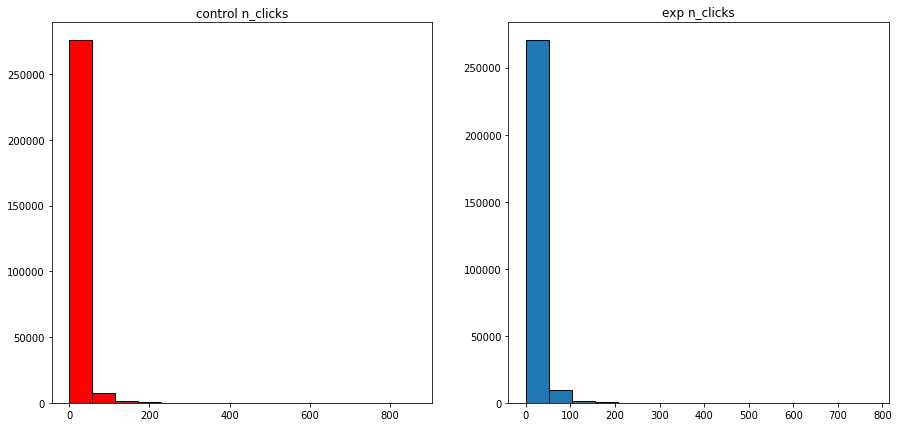

In [40]:
def make_hist(x, y, bins = 15):
    plt.figure(1, figsize = (15,7))

    plt.subplot(1, 2, 1)
    plt.title('control n_clicks')
    plt.hist(x, edgecolor = 'k', color = 'r', bins = bins)

    plt.subplot(1, 2, 2)
    plt.title('exp n_clicks')
    plt.hist(y, edgecolor = 'k', bins = bins)
    plt.show()
make_hist(control.n_clicks, _exp.n_clicks)
#pylab.scatter(exp.userID, _exp.n_clicks)
#распределение не похоже на нормальное даже близко: никаких критериев Стьюдента и вообще параметрических критериев

In [41]:
np.random.seed(0)

n_boot_samples = 500
control_mean_scores = get_bootstrap_samples(control.n_clicks.values, n_boot_samples)
means = control_mean_scores.mean(axis = 1)
delta = control_mean_scores - means[: , np.newaxis]
control_boot_chi_squared = sum(delta * delta, axis = 1)

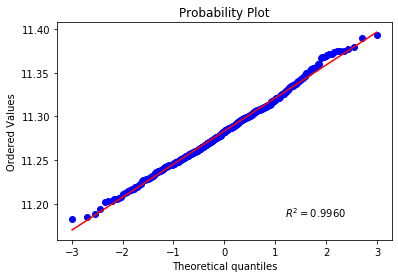

In [42]:
r = stats.probplot(means, plot = pylab, rvalue=True)
pylab.show()

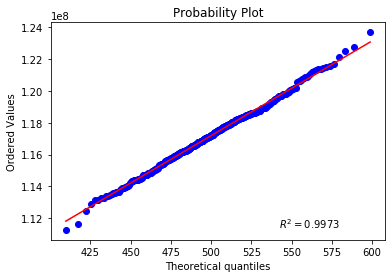

In [43]:
r = stats.probplot(control_boot_chi_squared, dist = 'chi2', sparams = (len(control_boot_chi_squared) - 1), 
               plot = pylab, rvalue=True)

In [44]:
stats.mannwhitneyu(_exp.n_clicks.values, control.n_clicks.values, alternative = 'two-sided')

MannwhitneyuResult(statistic=41184125116.0, pvalue=6.247235801369629e-75)

In [45]:
browsers_nclicks_exp = data.loc[_exp.index].groupby(['browser', 'userID']).sum().loc[:,'n_clicks']
browsers_nclicks_ctrl = data.loc[control.index].groupby(['browser', 'userID']).sum().loc[:,'n_clicks']

In [60]:
browsers = np.unique(data.browser)
print('Without multitest: \n')
ps = np.empty(browsers.shape[0])
for i, browser in enumerate(browsers):
    _, ps[i] = stats.mannwhitneyu(browsers_nclicks_exp.loc[browser, :], browsers_nclicks_ctrl.loc[browser, :])
    print(browser, ps[i])
    
print('With multitest: \n')
_, p_corr, _, _ = multipletests(ps, alpha = 0.05, method = 'holm')
for i, browser in enumerate(browsers):
    print(browser, p_corr[i])
x = 0
print([x < 0.05 for x in p_corr])

Without multitest: 

Browser #14 0.0
Browser #17 0.03740060143010802
Browser #2 0.0272438604197241
Browser #20 0.45366656388735377
Browser #22 0.2574055152210032
Browser #4 0.40760617658454984
With multitest: 

Browser #14 0.0
Browser #17 0.14960240572043207
Browser #2 0.13621930209862051
Browser #20 0.8152123531690997
Browser #22 0.7722165456630096
Browser #4 0.8152123531690997
[True, False, False, False, False, False]


Для каждого браузера в каждой из двух групп (control и exp) посчитаем долю запросов, в которых пользователь не кликнул ни разу. Это можно сделать, поделив сумму значений n_nonclk_queries на сумму значений n_queries. Умножив это значение на 100, получим процент некликнутых запросов, который можно легче проинтерпретировать.

In [71]:
browsers_nonclk_q_exp = data.loc[_exp.index].groupby(['browser']).sum().loc[:,'n_nonclk_queries']
browsers_clk_q_exp = data.loc[_exp.index].groupby(['browser']).sum().loc[:,'n_queries']
browsers_nonclk_q_prop_exp = round(browsers_nonclk_q_exp / browsers_clk_q_exp * 100, 2)

browsers_nonclk_q_ctrl = data.loc[control.index].groupby(['browser']).sum().loc[:,'n_nonclk_queries']
browsers_clk_q_ctrl = data.loc[control.index].groupby(['browser']).sum().loc[:,'n_queries']
browsers_nonclk_q_prop_ctrl = round(browsers_nonclk_q_ctrl / browsers_clk_q_ctrl * 100, 2)

print('Control / experimental groups')
for br in browsers:
    print(br),
    print("ctrl: ", browsers_nonclk_q_prop_ctrl.loc[browsers_nonclk_q_prop_ctrl.index == br].values),
    print("exp: ", browsers_nonclk_q_prop_exp.loc[browsers_nonclk_q_prop_ctrl.index == br].values)
    print('\n')

Control / experimental groups
Browser #14
ctrl:  [57.59]
exp:  [43.76]


Browser #17
ctrl:  [36.3]
exp:  [36.94]


Browser #2
ctrl:  [45.96]
exp:  [44.98]


Browser #20
ctrl:  [40.54]
exp:  [38.98]


Browser #22
ctrl:  [40.59]
exp:  [39.85]


Browser #4
ctrl:  [46.97]
exp:  [45.14]


